In [1]:
import librosa

array, sampling_rate = librosa.load(librosa.ex("trumpet"))

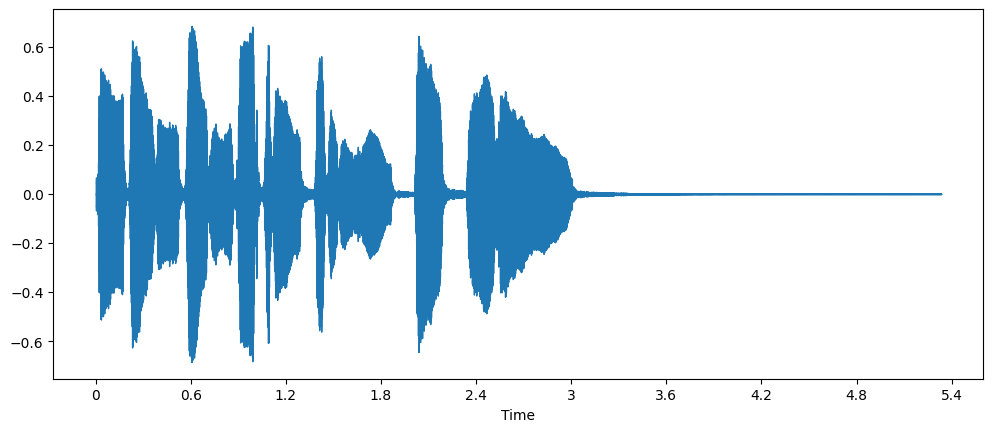

In [2]:
import matplotlib.pyplot as plt
import librosa.display

plt.figure().set_figwidth(12)
librosa.display.waveshow(array, sr=sampling_rate)

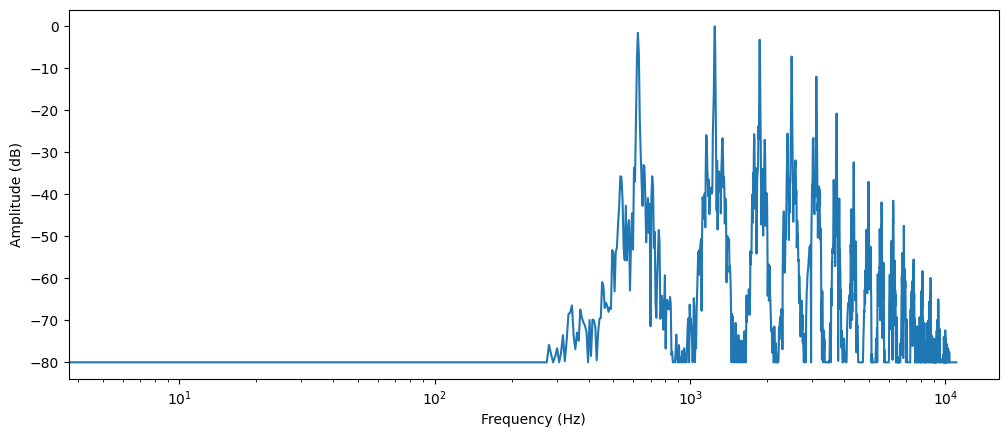

In [3]:
import numpy as np

dft_input = array[:4096]

# Рассчитаем ДПФ
window = np.hanning(len(dft_input))
windowed_input = dft_input * window
dft = np.fft.rfft(windowed_input)

# получим амплитудный спектр в децибелах
amplitude = np.abs(dft)
amplitude_db = librosa.amplitude_to_db(amplitude, ref=np.max)

# получим частотные столбцы
frequency = librosa.fft_frequencies(sr=sampling_rate, n_fft=len(dft_input))

plt.figure().set_figwidth(12)
plt.plot(frequency, amplitude_db)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude (dB)")
plt.xscale("log")

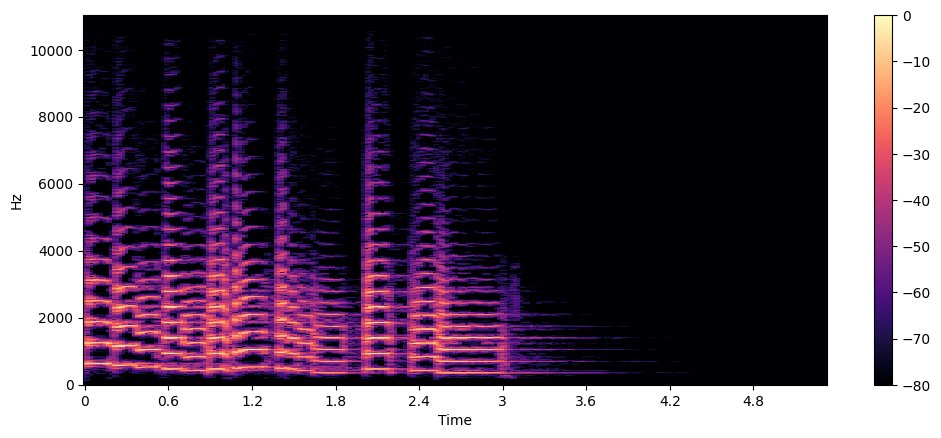

In [4]:
import numpy as np

D = librosa.stft(array)
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

plt.figure().set_figwidth(12)
librosa.display.specshow(S_db, x_axis="time", y_axis="hz")
plt.colorbar()

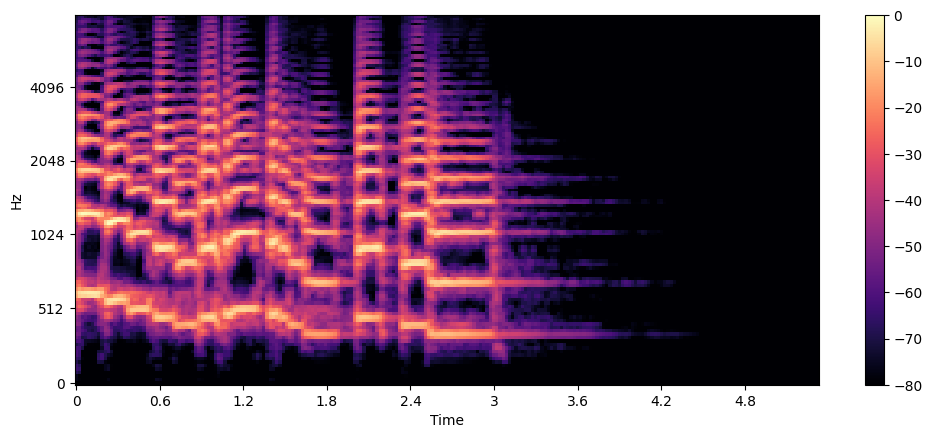

In [5]:
S = librosa.feature.melspectrogram(y=array, sr=sampling_rate, n_mels=128, fmax=8000)
S_dB = librosa.power_to_db(S, ref=np.max)

plt.figure().set_figwidth(12)
librosa.display.specshow(S_dB, x_axis="time", y_axis="mel", sr=sampling_rate, fmax=8000)
plt.colorbar()

In [ ]:
# (предполагается, что numpy, torch, tqdm, f1_score и т.д. уже импортированы выше)

history = {
  "tr_loss": [],
  "tr_acc": [],
  "va_loss": [],
  "va_acc": [],
  "va_f1": []   # добавили поле для f1
}

def run_epoch(loader, train=True, tag=""):
    model.train() if train else model.eval()
    loss_sum, correct, total = 0.0, 0, 0
    preds_list = []
    trues_list = []
    for xb_wave, yb in tqdm(loader, desc=tag, leave=False):
        xb_wave, yb = xb_wave.to(device), yb.to(device)
        xb = to_logmel_batch(xb_wave)
        if train: opt.zero_grad(set_to_none=True)
        with torch.set_grad_enabled(train):
            logits = model(xb)
            loss = crit(logits, yb)
            if train:
                loss.backward(); opt.step()
        loss_sum += loss.item()*xb.size(0)
        pred = logits.argmax(1)
        correct += (pred==yb).sum().item()
        total += xb.size(0)

        # собираем для метрик (только сохраняем на CPU numpy)
        preds_list.append(pred.cpu().numpy())
        trues_list.append(yb.cpu().numpy())

    preds = np.concatenate(preds_list)
    trues = np.concatenate(trues_list)
    return loss_sum/total, correct/total, trues, preds

epochs = 10
for ep in range(1, epochs + 1):
    tr_l, tr_a, _, _ = run_epoch(train_loader, True,  f"train {ep}/{epochs}")
    va_l, va_a, y_true_va, y_pred_va = run_epoch(val_loader,   False, f"valid {ep}/{epochs}")

    # считаем f1 (macro) на валидации
    va_f1 = f1_score(y_true_va, y_pred_va, average="macro")

    print(f"Ep {ep:02d}: train {tr_l:.4f}/{tr_a:.3f} | valid {va_l:.4f}/{va_a:.3f} | valid f1 {va_f1:.4f}")

    history["tr_loss"].append(tr_l)
    history["tr_acc"].append(tr_a)
    history["va_loss"].append(va_l)
    history["va_acc"].append(va_a)
    history["va_f1"].append(va_f1)

# Тест
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for xb_wave, yb in tqdm(test_loader, desc="test", leave=False):
        logits = model(to_logmel_batch(xb_wave.to(device)))
        y_true += yb.numpy().tolist()
        y_pred += logits.argmax(1).cpu().numpy().tolist()

cnn_test_acc = accuracy_score(y_true, y_pred)
cnn_test_f1  = f1_score(y_true, y_pred, average="macro")
print("CNN TEST acc:", cnn_test_acc, "f1_macro:", cnn_test_f1)
